<a href="https://colab.research.google.com/github/elsa9421/Interactive-IPython-Demos/blob/main/Boosting_AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This IPython Notebook demonstrates AdaBoost Boosting Algorithm



## Boosting :

In machine learning, boosting is an ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones
<br>The output of a `weak learner` is a `base classifier` that is only slightly correlated with the true classification 
<br>i.e it can label examples better than random guessing 
<br>In contrast, the output of a  `strong learner` is a classifier that is arbitrarily well-correlated with the true classification.

## AdaBoost
`AdaBoost`, short for `Adaptive Boosting`, is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire
The output of the `weak learners` (`base classifier`) is combined into a weighted sum that represents the final output of the boosted classifier. <br> `AdaBoost` is adaptive in the sense that subsequent weak learners are tweaked such that after each iteration, we re-weight the dataset to assign greater importance to data points which were misclassified by the previous weak learner, so that those data points get special attention during the next iteration .







Credit : https://geoffruddock.com/adaboost-from-scratch-in-python/

# Dataset

We will generate a toy dataset using using less data points. The key here is that we want to have two classes which are not linearly separable, since this is the ideal use-case for AdaBoost.

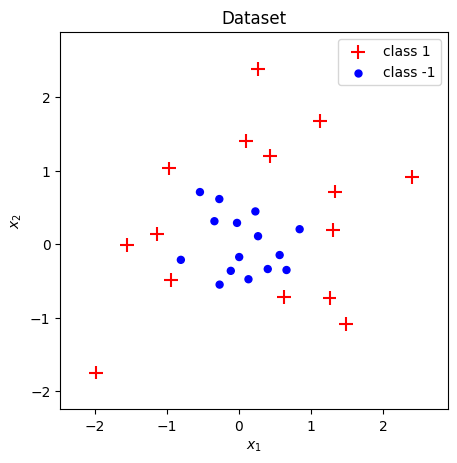

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split


def plot_adaboost(X,y,clf=None,sample_weights = None, annotate= False, ax= None,title=None): 
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100
    

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red',label="class 1")

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue',label="class -1")

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
    
    if title:
      plt.title(title)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()



def make_toy_dataset(n: int = 100, random_seed: int = None):
    """ Generate a toy dataset for evaluating AdaBoost classifiers """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_toy_dataset(n=30, random_seed=10)
plot_adaboost(X, y,title="Dataset")

## The AdaBoost Algorithm 

 

A)   Initialize sample weights uniformly as $w_i^1= 1/n$ , where $n$ = number of data points
B)  For each iteration $t$:
>
 1. Find weak learner $h_t(x)$ which minimizes $\epsilon_t = $ $\Sigma_{i=1}^n$ $\mathbb{1}$ $[h_t(x_i) \neq$ $y_i] w_i^{(t)}$
 <br>
 2.  We set a weight for our weak learner based on its accuracy: $alpha_t =  {\dfrac{1}{2}} ln({\dfrac{1-\epsilon_t}{\epsilon_t}})$ 
 3. Increase weights of misclassified observations: $w_i^{(t+1)}=w_i^{(t)}.e^{-\alpha^t y_i h_t(x_i)}$
 4. Renormalize weights, so that $\Sigma_{i=1}^n w_i^{(t+1)}=1$

C)   Make final prediction as weighted majority vote of weak learner predictions:
$H(x)= sign( \Sigma_{t=1}^T \alpha_t h_t(x))$



The table below shows a mapping between the variable names we will use and the math notation used earlier in the description of the algorithm.

|  Variable                            | Math        |
|--------------------------------------|-------------|
|   sample weights with shape: (T, n)  | $w_i^{(t)}$ | 
|   stumps with shape: (T, )           |  $h_t{(x)}$ | 
|   stump_weights with shape (T, )     | $\alpha_t$  |
|errors with shape: (T, )    | $\epsilon_t$ |
|clf.predict(X)	| $H_t {(x)}$|


## Implementation Notes:

* Here, the weak learner $h_t(x)$ is `DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)`

* We set the initial uniform sample weights outside of the for-loop and set the weights for `t+1` within each iteration , unless it is the last iteration. 

About the Plot :

* Two plots are generated for each iteration
<br>`Plot 1`: Base classifier at the particular iteration
<br>`Plot 2`: Output of the Strong learner generated by weighted majority vote of weak learner prediction (as specified in Step C)

* In order to visualize the weights at each iteration, the code is written such that the sizes of the  misclassified observations are proportional to weights assigned to them. (The weights are assigned according to step 3)
<br> For example, if `datapoint k` is missclassified in `iteration t`, then weight is increased for `datapoint k` in iteration `t+1`, and the marker size for the `datapoint k` is increased in iteration `t+1`





Button(description='Next Iteration', style=ButtonStyle())

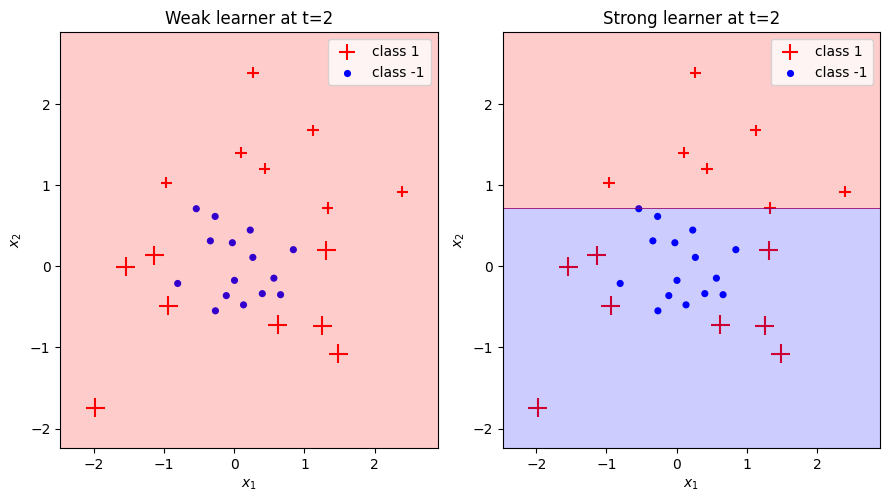

In [ ]:
class AdaBoost:
    """ 
    AdaBoost enemble classifier from scratch
    
    -sample_weights with shape: (T, n)
    -stumps with shape: (T, )
    -stump_weights with shape (T, )
    -errors with shape: (T, )
    
    
    """

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

from sklearn.tree import DecisionTreeClassifier

def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    # init numpy arrays
    self.sample_weights = np.zeros(shape=(iters, n))
    self.stumps = np.zeros(shape=iters, dtype=object)
    self.stump_weights = np.zeros(shape=iters)
    self.errors = np.zeros(shape=iters)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    for t in range(iters):
        # fit  weak learner
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()# / n
        stump_weight = np.log((1 - err) / err) / 2

        # update sample weights
        new_sample_weights = (
            curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
        )
        
        new_sample_weights /= new_sample_weights.sum()

        # If not final iteration, update sample weights for t+1
        if t+1 < iters:
            self.sample_weights[t+1] = new_sample_weights

        # save results of iteration
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self

def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))

# assign our individually defined functions as methods of our classifier
AdaBoost.fit = fit
AdaBoost.predict = predict

clf = AdaBoost().fit(X, y, iters=10)


def truncate_adaboost(clf, t: int):
    """ Truncate a fitted AdaBoost up to (and including) a particular iteration """
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=10):
    """ Plot weak learner and cumulaive strong learner at each iteration. """
    
    # larger grid
    fig, axes = plt.subplots(figsize=(9,1*5),
                             nrows=1,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    # fig, axes=plt.subplot(figsize=(8,8))
    
    fig.set_facecolor('white')

    #fig.suptitle('Decision boundaries by iteration')
    i=iters
    ax1, ax2 = axes[0],axes[1]

    # Plot weak learner
    _ = ax1.set_title(f'Weak learner at t={i + 1}')
    plot_adaboost(X, y, clf.stumps[i],
                  sample_weights=clf.sample_weights[i],
                  annotate=False, ax=ax1)

    # Plot strong learner
    trunc_clf = truncate_adaboost(clf, t=i + 1)
    _ = ax2.set_title(f'Strong learner at t={i + 1}')
    plot_adaboost(X, y, trunc_clf,
                  sample_weights=clf.sample_weights[i],
                  annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

clf = AdaBoost().fit(X, y, iters=15)

next=0


### Just create a button for iters

button = widgets.Button(description="Next Iteration")
output = widgets.Output()



def on_button_clicked(b):
  global next
  next+=1
  display.clear_output(wait=True)
  if next<14:
    display.display(button)
  plot_staged_adaboost(X, y, clf,next)


button.on_click(on_button_clicked)
display.display(button)
plot_staged_adaboost(X, y, clf,next)




## Benchmark with scikit-Learn
 
Use `AdaBoostClassifier` by importing it  from sckit-learn 
[Read more](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)


Train error: 0.0%


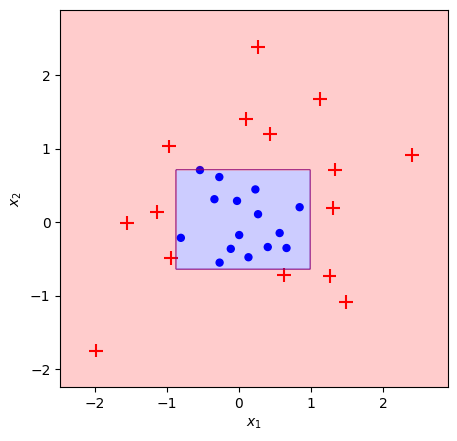

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

bench = AdaBoostClassifier(n_estimators=15, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, bench)

train_err = (bench.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')
